In this notebook, the influence of multiple values of $\delta t$ on particle distributions after 10 and 30 days is assessed.

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.collections as mc
import seaborn as sns
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from itertools import combinations

from importlib import reload
import sys
sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repo/tools')
import plot
import community
import fieldsetter_cmems
import advectParticles

In [5]:
reload(plot)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/science/users/4302001/arctic-connectivity/tools/advectParticles.py'>

In [6]:
pset_path = '/data/oceanparcels/output_data/data_Daan/psets/'

In [7]:
ds_dt1 = xr.open_dataset(pset_path+'pset_Rcmems_Pico11_S2001-1-1_D30_DT1_ODT24.nc')
ds_dt5 = xr.open_dataset(pset_path+'pset_Rcmems_Pico11_S2001-1-1_D30_DT5_ODT24.nc')
ds_dt20 = xr.open_dataset(pset_path+'pset_Rcmems_Pico11_S2001-1-1_D30_DT20_ODT24.nc')
ds_dt60 = xr.open_dataset(pset_path+'pset_Rcmems_Pico11_S2001-1-1_D30_DT60_ODT24.nc')

# Indices

``ds_dt60a`` covers a time span of 90 days, while ``ds_dt1``, ``ds_dt5`` and ``ds_dt20`` cover a time span of 30 days, This means we have to be careful with choosing the correct value in ``ds_dt60a`` so we match up our data with ``ds_dt5``. The correct index is ``60``:

In [9]:
ds_dt1.time[0,30].values

numpy.datetime64('2001-01-31T12:00:00.000000000')

In [10]:
ds_dt5.time[0,30].values

numpy.datetime64('2001-01-31T12:00:00.000000000')

In [11]:
ds_dt20.time[0,30].values

numpy.datetime64('2001-01-31T12:00:00.000000000')

In [15]:
ds_dt60.time[1,30].values

numpy.datetime64('2001-01-31T12:00:00.000000000')

In [16]:
ds_dt60.lat[0,30].values

array(nan, dtype=float32)

In [22]:
ds_dt1

<xarray.Dataset>
Dimensions:       (obs: 31, traj: 1450665)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory    (traj, obs) float64 ...
    time          (traj, obs) datetime64[ns] ...
    lat           (traj, obs) float32 ...
    lon           (traj, obs) float32 ...
    z             (traj, obs) float32 ...
    beached       (traj, obs) float32 ...
    unbeachCount  (traj, obs) float32 ...
    inBounds      (traj, obs) float32 ...
Attributes:
    feature_type:                    trajectory
    Conventions:                     CF-1.6/CF-1.7
    ncei_template_version:           NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:                 2.0.1.dev321+gd7c8d1d
    parcels_mesh:                    spherical
    dt:                              0:01:00
    Output dt:                       1 day, 0:00:00
    Runtime:                         30 days, 0:00:00
    Release time of first particle:  2001-01-01 12:00:00

# Position comparison
Since both simulations stem from the same original particle grid, we can readily compare the final positions of the particles. First, we can check whether all initial positions are equal.

In [23]:
np.all(np.array([np.all(ds_dt1.lon[::1000,0] == ds_dt5.lon[::1000,0]), 
                 np.all(ds_dt1.lon[::1000,0] == ds_dt20.lon[::1000,0]),
                 np.all(ds_dt1.lon[::1000,0] == ds_dt60.lon[::1000,0]),
                ]))

True

In [30]:
noNaN = np.logical_and(np.logical_and(~np.isnan(ds_dt1.lon[::1000,30]), ~np.isnan(ds_dt5.lon[::1000,30])), np.logical_and(~np.isnan(ds_dt20.lon[::1000,30]), ~np.isnan(ds_dt60.lon[::1000,30])))

## Drift distances
We can now simply take the euclidian difference between each final location. First we have to define a function to compute distances using the Haversine formula<sup>[1]</sup>.

[1]: https://medium.com/@petehouston/calculate-distance-of-two-locations-on-earth-using-python-1501b1944d97

In [24]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [31]:
final_loc = {
             '1' : (ds_dt1.lon[::1000,30][noNaN], ds_dt1.lat[::1000,30][noNaN]),
             '5' : (ds_dt5.lon[::1000,30][noNaN], ds_dt5.lat[::1000,30][noNaN]),
             '20' : (ds_dt20.lon[::1000,30][noNaN], ds_dt20.lat[::1000,30][noNaN]),
             '60' : (ds_dt60.lon[::1000,30][noNaN], ds_dt60.lat[::1000,30][noNaN]),
         }

In [33]:
dist_diff = {}
for combo in combinations(final_loc.keys(), 2):
    dist_diff[combo] = haversine(final_loc[combo[0]][0],
                                 final_loc[combo[0]][1],
                                 final_loc[combo[1]][0],
                                 final_loc[combo[1]][1])

In [34]:
dist_diff_stats = {}
for key in dist_diff.keys():
    dist_diff_stats[key] = {'mean' : dist_diff[key].mean().values,
                            'std' : dist_diff[key].std().values,
                            'max' : dist_diff[key].max().values}

In [35]:
dist_diff_stats

{('1', '5'): {'mean': array(3.030194, dtype=float32),
  'std': array(10.197009, dtype=float32),
  'max': array(187.74377, dtype=float32)},
 ('1', '20'): {'mean': array(2.9585853, dtype=float32),
  'std': array(9.744708, dtype=float32),
  'max': array(192.11209, dtype=float32)},
 ('1', '60'): {'mean': array(3.0947516, dtype=float32),
  'std': array(10.775781, dtype=float32),
  'max': array(195.1535, dtype=float32)},
 ('5', '20'): {'mean': array(0.46793166, dtype=float32),
  'std': array(3.7093956, dtype=float32),
  'max': array(108.37807, dtype=float32)},
 ('5', '60'): {'mean': array(0.76588243, dtype=float32),
  'std': array(6.309942, dtype=float32),
  'max': array(131.31943, dtype=float32)},
 ('20', '60'): {'mean': array(0.42803952, dtype=float32),
  'std': array(5.0988617, dtype=float32),
  'max': array(130.41902, dtype=float32)}}

In [36]:
sorted_dist_diff = {}
for key in dist_diff:
    sorted_dist_diff[key] = np.sort(dist_diff[key])

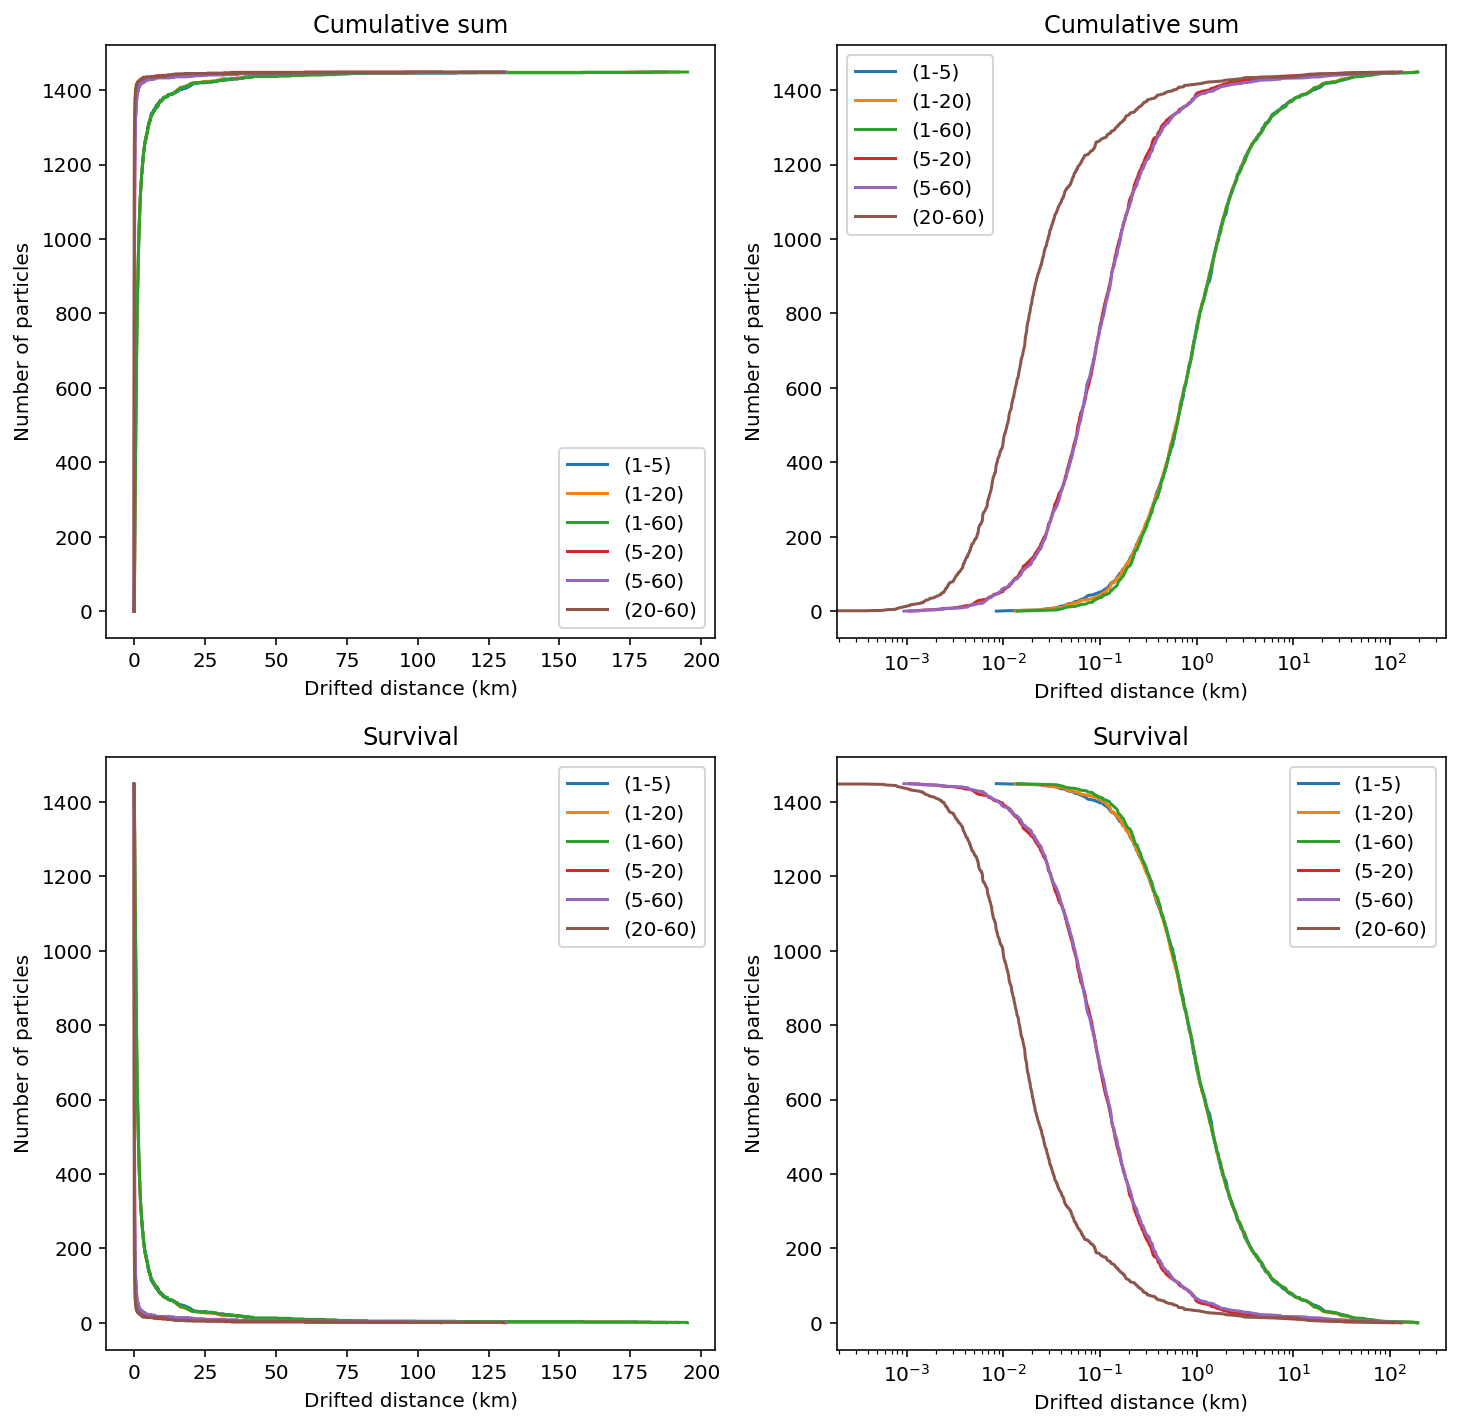

In [37]:
fig, axes = plt.subplots(2,2, figsize=(12,12))
for key in dist_diff.keys():
    axes[0,0].step(sorted_dist_diff[key], np.arange(sorted_dist_diff[key].size), label=f'({key[0]}-{key[1]})')
axes[0,0].set_xlabel('Drifted distance (km)')
axes[0,0].set_ylabel('Number of particles')
axes[0,0].title.set_text('Cumulative sum')
axes[0,0].legend()

for key in dist_diff.keys():
    axes[0,1].plot(sorted_dist_diff[key], np.arange(sorted_dist_diff[key].size), label=f'({key[0]}-{key[1]})')
axes[0,1].set_xscale('log')
axes[0,1].set_xlabel('Drifted distance (km)')
axes[0,1].set_ylabel('Number of particles')
axes[0,1].legend()
axes[0,1].title.set_text('Cumulative sum')

for key in dist_diff.keys():
    axes[1,0].step(sorted_dist_diff[key][::-1], np.arange(sorted_dist_diff[key].size), label=f'({key[0]}-{key[1]})')
axes[1,0].set_xlabel('Drifted distance (km)')
axes[1,0].set_ylabel('Number of particles')
axes[1,0].title.set_text('Survival')
axes[1,0].legend()

for key in dist_diff.keys():
    axes[1,1].plot(sorted_dist_diff[key][::-1], np.arange(sorted_dist_diff[key].size), label=f'({key[0]}-{key[1]})')
axes[1,1].set_xscale('log')
axes[1,1].set_xlabel('Drifted distance (km)')
axes[1,1].set_ylabel('Number of particles')
axes[1,1].legend()
axes[1,1].title.set_text('Survival')

plt.savefig('figures/drift_distributions.eps')
plt.show()

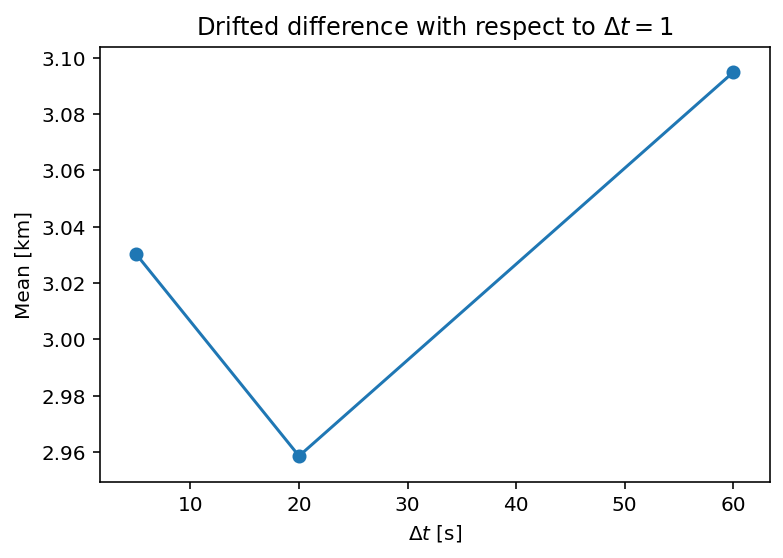

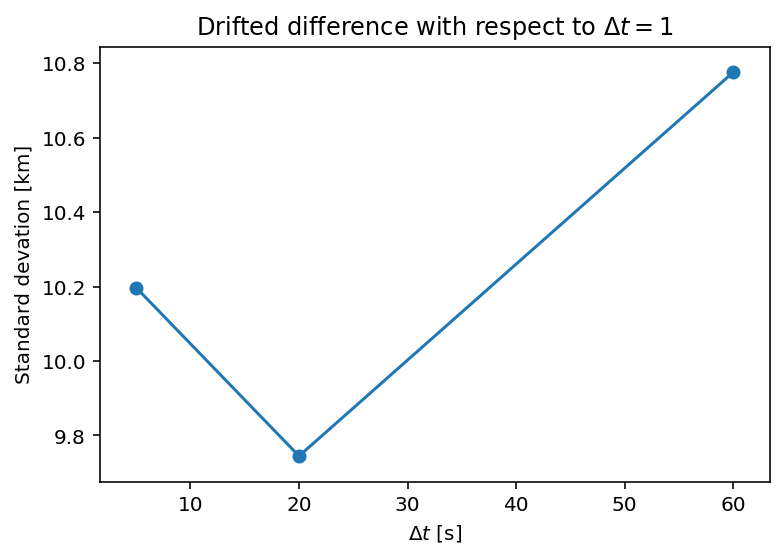

In [38]:
plt.plot([5, 20, 60], [dist_diff_stats[('1', '5')]['mean'], dist_diff_stats[('1', '20')]['mean'], dist_diff_stats[('1', '60')]['mean']])
plt.scatter([5, 20, 60], [dist_diff_stats[('1', '5')]['mean'], dist_diff_stats[('1', '20')]['mean'], dist_diff_stats[('1', '60')]['mean']])
plt.xlabel(r'$\Delta t$ [s]')
plt.ylabel('Mean [km]')
plt.title(r'Drifted difference with respect to $\Delta t=1$')
plt.savefig('figures/drift_mean.eps')
plt.show()

plt.plot([5, 20, 60], [dist_diff_stats[('1', '5')]['std'], dist_diff_stats[('1', '20')]['std'], dist_diff_stats[('1', '60')]['std']])
plt.scatter([5, 20, 60], [dist_diff_stats[('1', '5')]['std'], dist_diff_stats[('1', '20')]['std'], dist_diff_stats[('1', '60')]['std']])
plt.xlabel(r'$\Delta t$ [s]')
plt.ylabel('Standard devation [km]')
plt.title(r'Drifted difference with respect to $\Delta t=1$')
plt.savefig('figures/drift_std.eps')
plt.show()